In [20]:
import pandas as pd
import networkx as nx
import pickle
import json
import utils

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16,9)
font = {'size'   : 22}
matplotlib.rc('font', **font)

# User Functions

In [21]:
def get_domain_to_cell_nodes_dict(G, attr_to_domains):
    '''
    Arguments
    -------
    G (networkx graph): bipartite graph representation of a dataset with attr and cell nodes

    attr_to_domains (dict): Maps each attribute node to a list of domain IDs

    Returns
    -------
    A dictionary keyed by domain_id and maps to a set of cell node values that map to that domain
    '''
    domain_id_to_cell_nodes = {}

    attr_nodes = [n for n, d in G.nodes(data=True) if d['type']=='attr']
    for attr in attr_nodes:
        cell_nodes_of_attr = utils.get_instances_for_attribute(G, attr)

        domains_ids = attr_to_domains[attr]
        # TODO: Maybe have option to only consider attributes that map to only one domain
        for id in domains_ids:
            if id not in domain_id_to_cell_nodes:
                domain_id_to_cell_nodes[id] = set(cell_nodes_of_attr)
            else:
                domain_id_to_cell_nodes[id].update(cell_nodes_of_attr)

    return domain_id_to_cell_nodes

def get_domain_to_col_names_dict(domain_id_to_tuples):
    '''
    Arguments
    -------
    domain_id_to_tuples (dict): Maps each domain_id to a list of (filename, column_name) tuples
    that make up the domain

    Returns
    -------
    A dictionary keyed by domain_id and maps to a set of cell node values that map to that domain
    '''
    domain_id_to_col_names = {}
    for id in domain_id_to_tuples:
        col_names = set()
        for tup in domain_id_to_tuples[id]:
            col_names.add(tup[1])
        domain_id_to_col_names[int(id)] = col_names
    return domain_id_to_col_names

def get_cell_node_to_domain_ids_dict(domain_id_to_cell_nodes):
    '''
    Arguments
    -------
    domain_id_to_cell_nodes (dict): Maps each domain_id to a to a set of cell node values that map to that domain

    Returns
    -------
    A dictionary keyed by the cell node and maps to the set of domain IDs
    '''
    cell_node_to_domain_ids = {}
    for id in domain_id_to_cell_nodes:
        for cell_node in domain_id_to_cell_nodes[id]:
            if cell_node not in cell_node_to_domain_ids:
                cell_node_to_domain_ids[cell_node] = set([id])
            else:
                cell_node_to_domain_ids[cell_node].add(id)
    return cell_node_to_domain_ids



# TUS Benchmark

In [22]:
# Read Graph
graph_path = '../graph_construction/combined_graphs_output/TUS/bipartite/bipartite.graph'
df_path = 'output/TUS_source_all_target_all/seed1/graph_stats_with_groundtruth_df.pickle'
domains_path = 'ground_truth/domain_info.json'

g = pickle.load(open(graph_path, 'rb'))
df = pickle.load(open(df_path, 'rb'))
df = df[df['node_type'] == 'cell']

# Read domains
with open(domains_path) as f:
  data = json.load(f)
  attr_to_domains = data['attributes']
  domain_id_to_tuples = data['domains']

In [23]:
# Get mapping of each domain_id to the set of cell nodes in that domain
domain_id_to_cell_nodes = get_domain_to_cell_nodes_dict(g, attr_to_domains)

# Construct dictionaries
domain_id_to_num_cell_nodes = {id: len(domain_id_to_cell_nodes[id]) for id in domain_id_to_cell_nodes}
domain_id_to_num_attr_nodes = {int(id): len(domain_id_to_tuples[id]) for id in domain_id_to_tuples}
domain_id_to_col_names = get_domain_to_col_names_dict(domain_id_to_tuples)

# Populate dataframe with statistics
df_dict = {'domain_id': [], 'num_cell_nodes': [], 'num_attr_nodes': [], 'num_col_names': []}
for id in domain_id_to_num_cell_nodes:
    df_dict['domain_id'].append(id)
    df_dict['num_cell_nodes'].append(domain_id_to_num_cell_nodes[id])
    df_dict['num_attr_nodes'].append(domain_id_to_num_attr_nodes[id])
    df_dict['num_col_names'].append(len(domain_id_to_col_names[id]))
domains_df = pd.DataFrame.from_dict(df_dict)

# Get avg cell cardinality for each domain
domain_id_to_avg_cell_card = {}
for id in domains_df['domain_id']:
    avg_card = df[df['node'].isin(domain_id_to_cell_nodes[id])]['cardinality'].mean()
    domain_id_to_avg_cell_card[id] = avg_card
domains_df['avg_cell_card'] = domains_df['domain_id'].map(domain_id_to_avg_cell_card)

domains_df

,domain_id,num_cell_nodes,num_attr_nodes,num_col_names,avg_cell_card
0,52,7,90,1,7.000000
1,5,314,270,3,158.283439
2,32,362,290,3,142.820442
3,17,6,80,1,2786.666667
4,58,5,110,1,37.000000
...,...,...,...,...,...
90,68,5,100,1,161.200000
91,43,9,84,1,96.222222
92,6,134,15,1,190.238806
93,27,3329,35,1,946.757284


In [24]:
# Map cell nodes to their set of domain IDs, and find cell nodes mapping to more than one domains
cell_node_to_domain_ids = get_cell_node_to_domain_ids_dict(domain_id_to_cell_nodes)
cell_nodes_in_multiple_domains = set()
for cell_node in cell_node_to_domain_ids:
    if len(cell_node_to_domain_ids[cell_node]) > 1:
        cell_nodes_in_multiple_domains.add(cell_node)
print("There are", len(cell_nodes_in_multiple_domains), "cell nodes that are placed in 2 or more domains.")

There are 9942 cell nodes that are placed in 2 or more domains.


In [25]:
homographs_from_df = set(df[df['is_homograph']==True]['node'].values)

intersection = homographs_from_df & cell_nodes_in_multiple_domains
difference = homographs_from_df - cell_nodes_in_multiple_domains 
print("Intersection size between homographs_from_df and cell_nodes_in_multiple_domains is:", len(intersection))

Intersection size between homographs_from_df and cell_nodes_in_multiple_domains is: 9942


In [26]:
values_in_multiple_domains = set()
multi_domain_attrs = 0
for attr in attr_to_domains:
    if len(attr_to_domains[attr]) > 1:
        multi_domain_attrs += 1
        cell_vals_for_attr = utils.get_instances_for_attribute(g, attr)
        values_in_multiple_domains.update(cell_vals_for_attr)

print("There are", multi_domain_attrs, "attribute nodes that map to more than one domain and there are", len(values_in_multiple_domains), "unique cell values in those attributes.")

There are 279 attribute nodes that map to more than one domain and there are 474 unique cell values in those attributes.


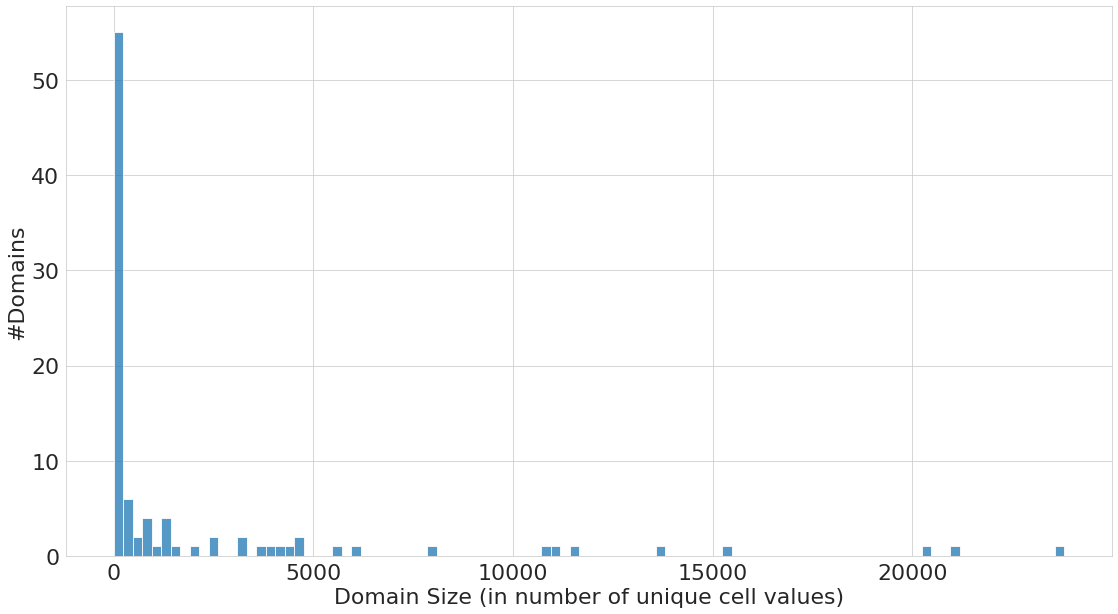

In [27]:
ax = sns.histplot(data=domains_df, x='num_cell_nodes', bins=100)
ax.set(xlabel='Domain Size (in number of unique cell values)', ylabel='#Domains')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_domain_size_histogram.svg')

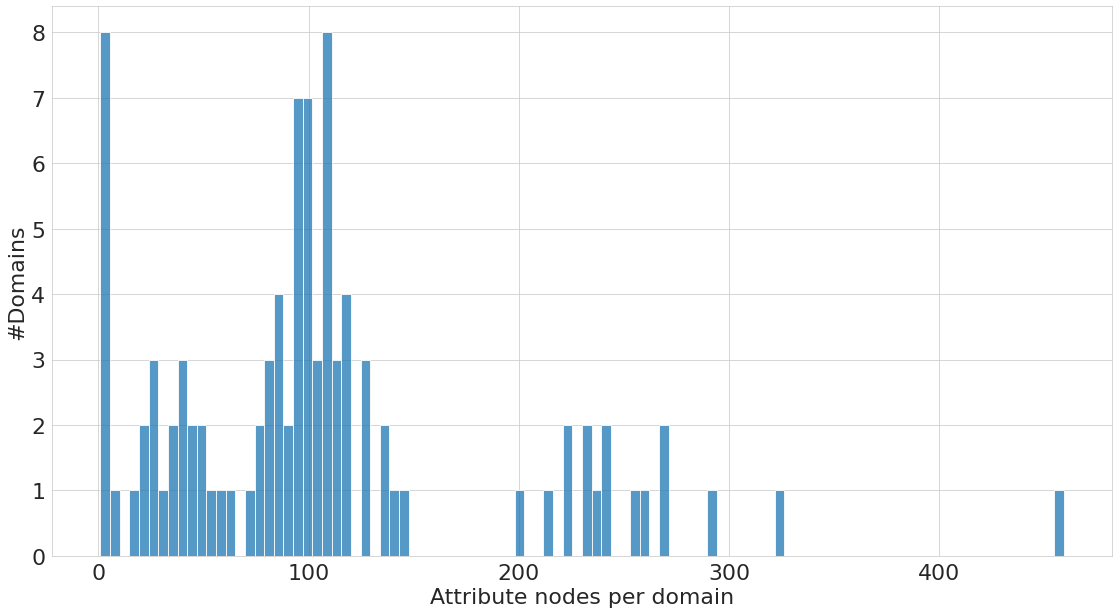

In [28]:
ax = sns.histplot(data=domains_df, x='num_attr_nodes', bins=100)
ax.set(xlabel='Attribute nodes per domain', ylabel='#Domains')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_attributes_per_domain_histogram.svg')

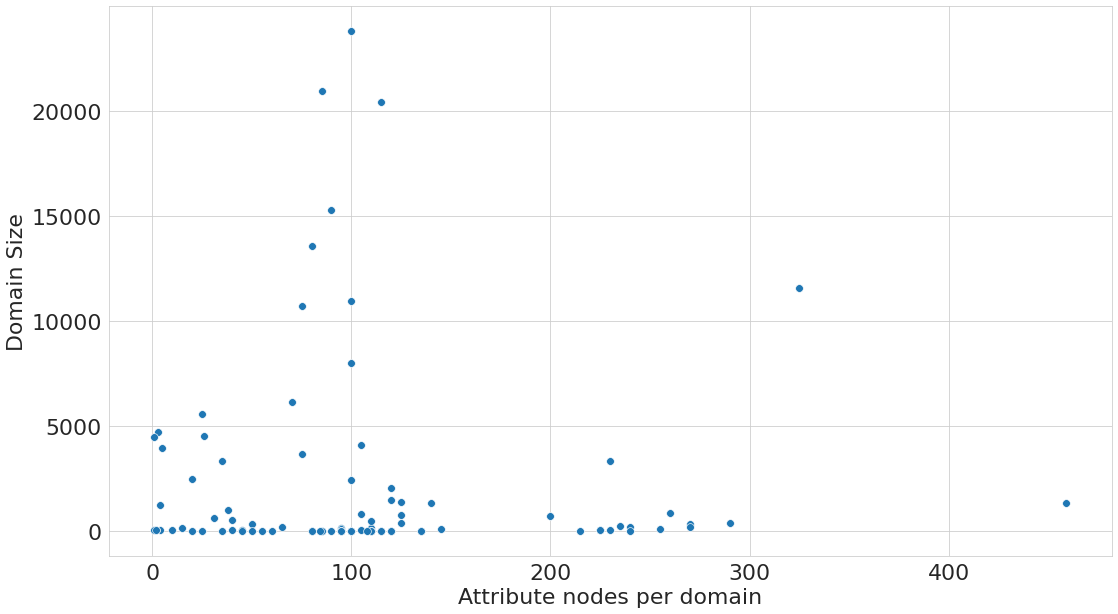

In [29]:
ax = sns.scatterplot(data=domains_df, x='num_attr_nodes', y='num_cell_nodes', s=60)
ax.set(xlabel='Attribute nodes per domain', ylabel='Domain Size')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_domain_size_vs_attributes_per_domain.svg')

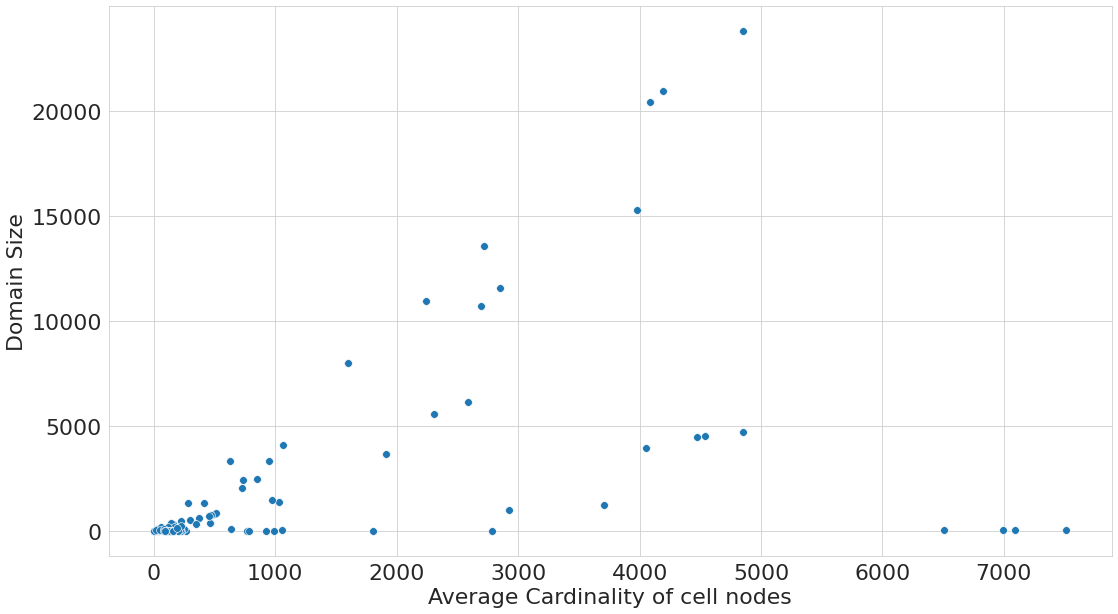

In [30]:
ax = sns.scatterplot(data=domains_df, x='avg_cell_card', y='num_cell_nodes', s=60)
ax.set(xlabel='Average Cardinality of cell nodes', ylabel='Domain Size')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_domain_size_vs_avg_cardinality.svg')

In [32]:
from tqdm import tqdm
# Update df to classify homographs based the inferred domains definition
node_to_is_domain_homograph = {} 
for node in df['node']:
    if node in cell_nodes_in_multiple_domains:
        node_to_is_domain_homograph[node] = True
    else:
        node_to_is_domain_homograph[node] = False
df['is_domain_homograph'] = df['node'].map(node_to_is_domain_homograph)

# Update df to specify combined domain size for each cell node
node_to_total_domain_size = {}
for node in tqdm(df['node']):
    domains = cell_node_to_domain_ids[node]
    cell_nodes = set()
    for id in domains:
        cell_nodes.update(domain_id_to_cell_nodes[id])
    node_to_total_domain_size[node] = len(cell_nodes)
df['total_domain_size'] = df['node'].map(node_to_total_domain_size)


measures=['approximate_betweenness_centrality', 'pagerank']
for measure in measures:
    df = utils.calculate_eval_measures_from_gt_column(df, measure, 'is_domain_homograph', len(cell_nodes_in_multiple_domains))
df.head()

100%|██████████| 190399/190399 [00:51<00:00, 3676.70it/s] 


,node,node_type,approximate_betweenness_centrality,is_homograph,has_missing_key,katz,harmonic_closeness,pagerank,cardinality,is_domain_homograph,...,approximate_betweenness_centrality_rank,approximate_betweenness_centrality_dense_rank,approximate_betweenness_centrality_precision,approximate_betweenness_centrality_recall,approximate_betweenness_centrality_f1_score,pagerank_rank,pagerank_dense_rank,pagerank_precision,pagerank_recall,pagerank_f1_score
191365,,cell,1.338285e-04,True,False,0.000049,0.096994,0.000830,786,True,...,13,13.0,1.000000,0.001308,0.002612,1,1.0,1.0,0.000101,0.000201
191380,Medium,cell,1.502401e-08,True,False,0.000010,0.068818,0.000192,9,True,...,9552,2012.0,0.415620,0.399316,0.407305,2,2.0,1.0,0.000201,0.000402
191387,Coarse,cell,1.410845e-08,True,False,0.000010,0.068745,0.000182,9,True,...,9742,2029.0,0.415212,0.406860,0.410994,3,3.0,1.0,0.000302,0.000603
191382,Fine,cell,1.036315e-08,True,False,0.000008,0.068548,0.000155,9,True,...,10698,2079.0,0.427557,0.460068,0.443217,4,4.0,1.0,0.000402,0.000804
191391,Strong,cell,2.492179e-06,True,False,0.000007,0.082054,0.000130,10,True,...,387,279.0,0.813953,0.031684,0.060993,5,5.0,1.0,0.000503,0.001005


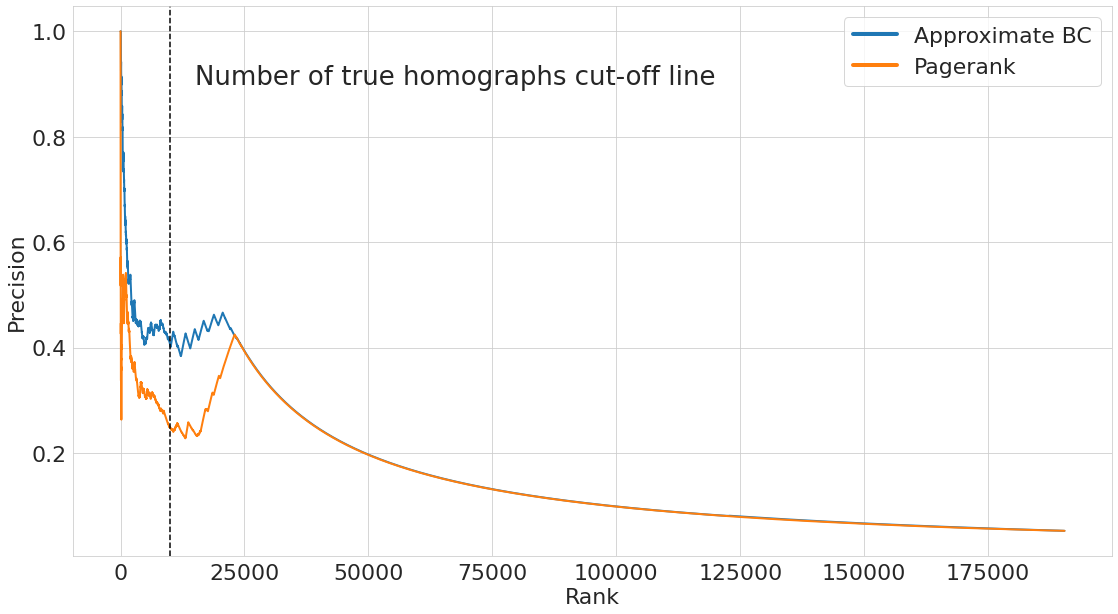

In [34]:
# Precision
k = df.shape[0]
ranks = list(range(1, k+1))

measure_names = ['Approximate BC', 'Pagerank']
for (measure, measure_name) in zip(measures, measure_names):
    vals = df.sort_values(by=[measure+'_rank'])[measure+'_precision'].values[0:k]
    plt.plot(ranks, vals, label=measure_name, linewidth=2)

plt.axvline(x=len(cell_nodes_in_multiple_domains), color='black', linestyle='--')
plt.text(len(cell_nodes_in_multiple_domains) + 5000, 0.90,'Number of true homographs cut-off line', fontsize=26)

plt.xlabel('Rank')
plt.ylabel('Precision')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_precision.svg')

[0.4079662]


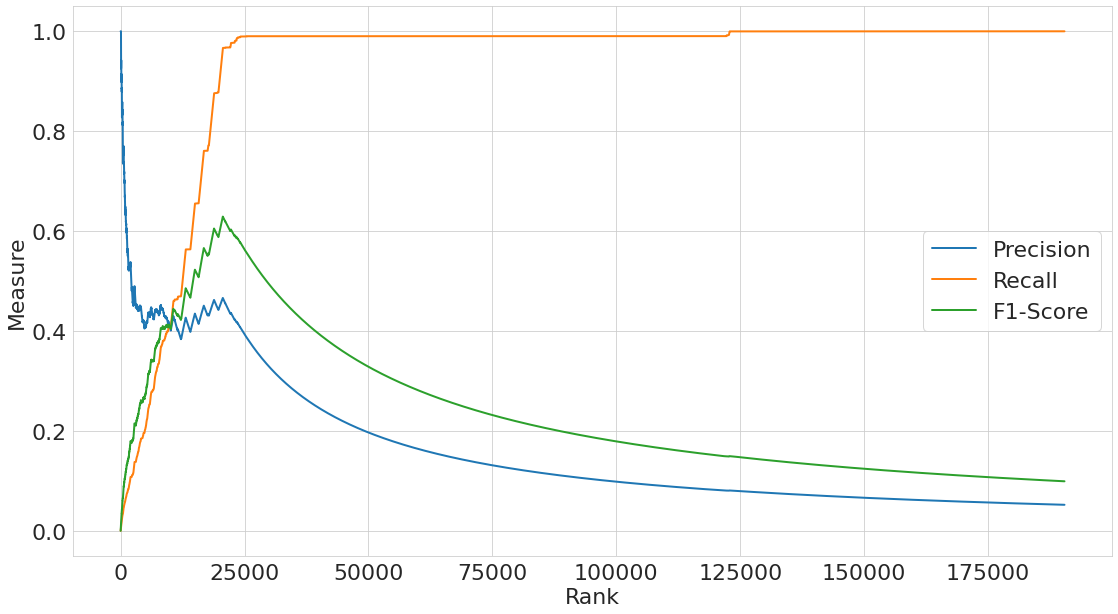

In [48]:
measure = 'approximate_betweenness_centrality'
print(df[df[measure+"_rank"] == len(cell_nodes_in_multiple_domains)][measure+"_precision"].values)
plt.plot(range(1, df.shape[0] + 1),df.sort_values(by=[measure+'_rank'])[measure+'_precision'], label='Precision', linewidth=2)
plt.plot(range(1, df.shape[0] + 1),df.sort_values(by=[measure+'_rank'])[measure+'_recall'], label='Recall', linewidth=2)
plt.plot(range(1, df.shape[0] + 1),df.sort_values(by=[measure+'_rank'])[measure+'_f1_score'], label='F1-Score', linewidth=2)
plt.xlabel('Rank')
plt.ylabel('Measure')
leg = plt.legend()
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_BC_evalutation.svg')

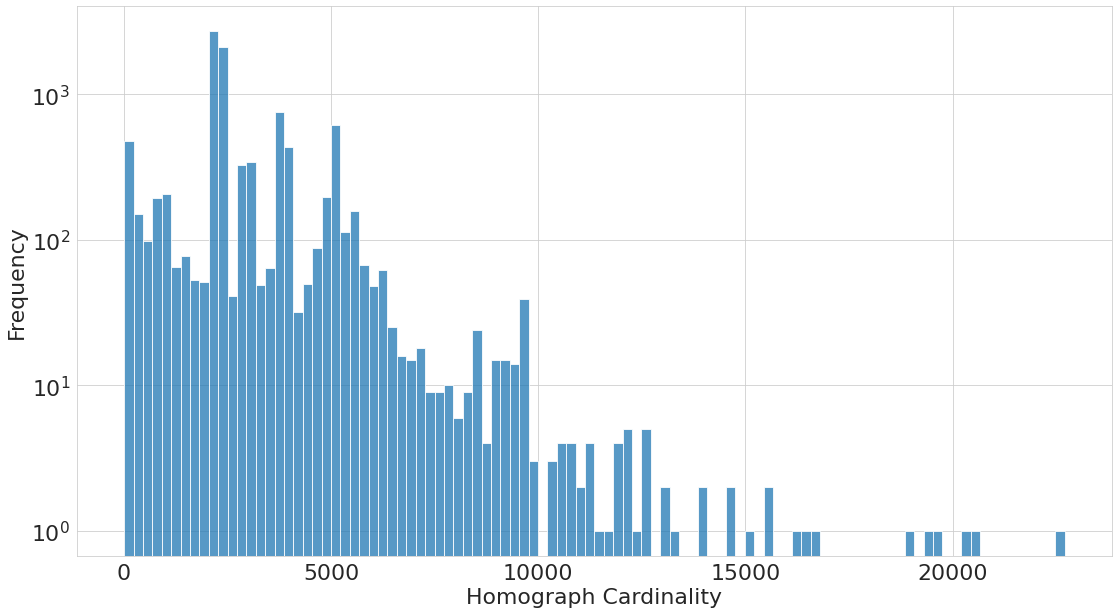

In [49]:
domain_homograph_df = df[df['is_domain_homograph'] == True]
ax = sns.histplot(data=domain_homograph_df, x='cardinality', bins=100)
ax.set(xlabel='Homograph Cardinality', ylabel='Frequency', yscale='log')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_homograph_cardinality_histogram.svg')

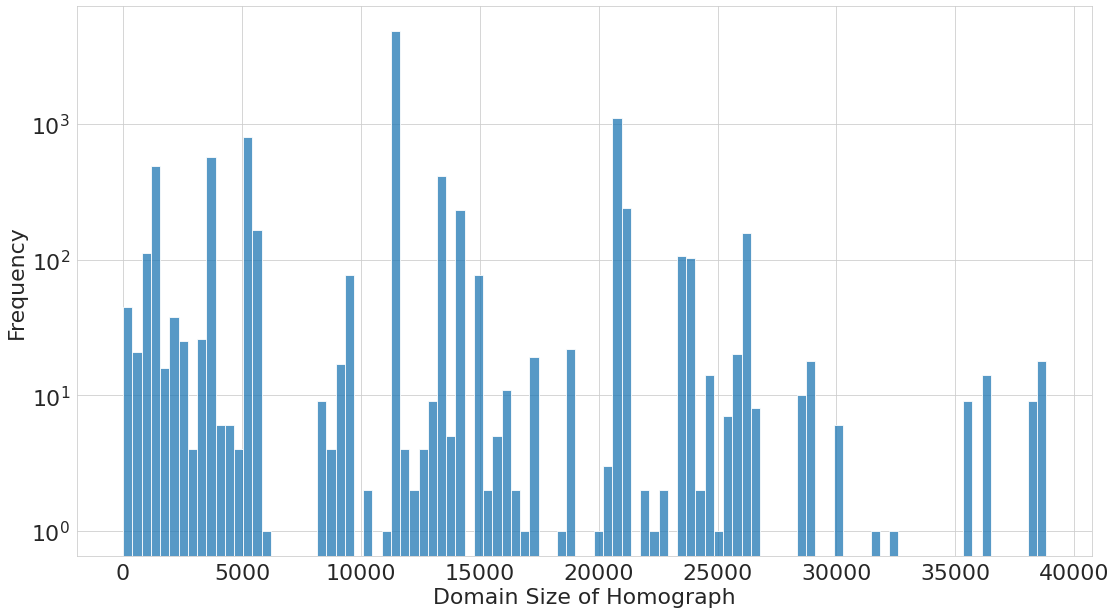

In [50]:
ax = sns.histplot(data=domain_homograph_df, x='total_domain_size', bins=100)
ax.set(xlabel='Domain Size of Homograph', ylabel='Frequency', yscale='log')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_homograph_domain_size_histogram.svg')

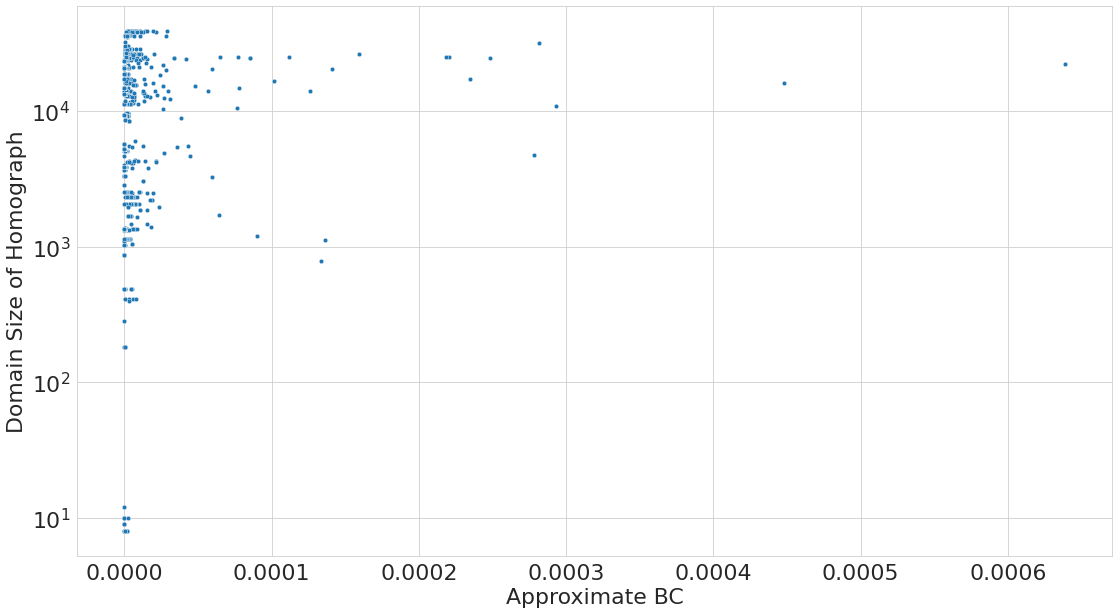

In [51]:
ax = sns.scatterplot(data=domain_homograph_df, x='approximate_betweenness_centrality', y='total_domain_size', s=20)
ax.set(xlabel='Approximate BC', ylabel='Domain Size of Homograph', yscale='log')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_domain_size_vs_BC.svg')

# TUS NO homographs

In [93]:
# Read Graph
graph_path = '../graph_construction/combined_graphs_output/TUS_no_homographs/bipartite/bipartite.graph'
df_path = 'output/TUS_no_homographs/graph_stats_with_groundtruth_df.pickle'
domains_path = 'ground_truth/domain_info_no_homographs.json'

g = pickle.load(open(graph_path, 'rb'))
df = pickle.load(open(df_path, 'rb'))
df = df[df['node_type'] == 'cell']

# Read domains
with open(domains_path) as f:
  data = json.load(f)
  attr_to_domains = data['attributes']
  domain_id_to_tuples = data['domains']

In [94]:
# Get mapping of each domain_id to the set of cell nodes in that domain
domain_id_to_cell_nodes = get_domain_to_cell_nodes_dict(g, attr_to_domains)

# Construct dictionaries
domain_id_to_num_cell_nodes = {id: len(domain_id_to_cell_nodes[id]) for id in domain_id_to_cell_nodes}
domain_id_to_num_attr_nodes = {int(id): len(domain_id_to_tuples[id]) for id in domain_id_to_tuples}
domain_id_to_col_names = get_domain_to_col_names_dict(domain_id_to_tuples)

# Populate dataframe with statistics
df_dict = {'domain_id': [], 'num_cell_nodes': [], 'num_attr_nodes': [], 'num_col_names': []}
for id in domain_id_to_num_cell_nodes:
    df_dict['domain_id'].append(id)
    df_dict['num_cell_nodes'].append(domain_id_to_num_cell_nodes[id])
    df_dict['num_attr_nodes'].append(domain_id_to_num_attr_nodes[id])
    df_dict['num_col_names'].append(len(domain_id_to_col_names[id]))
domains_df = pd.DataFrame.from_dict(df_dict)

# Get avg cell cardinality for each domain
domain_id_to_avg_cell_card = {}
for id in domains_df['domain_id']:
    avg_card = df[df['node'].isin(domain_id_to_cell_nodes[id])]['cardinality'].mean()
    domain_id_to_avg_cell_card[id] = avg_card
domains_df['avg_cell_card'] = domains_df['domain_id'].map(domain_id_to_avg_cell_card)

domains_df

,domain_id,num_cell_nodes,num_attr_nodes,num_col_names,avg_cell_card
0,39,7,90,1,7.000000
1,45,5,80,1,5.000000
2,21,4,110,1,4.000000
3,27,5,85,1,5.000000
4,40,613,31,1,363.525285
...,...,...,...,...,...
64,12,3,100,1,3.000000
65,34,4,100,1,4.000000
66,66,122,15,1,70.459016
67,42,3329,35,1,946.757284


In [95]:
# Map cell nodes to their set of domain IDs, and find cell nodes mapping to more than one domains
cell_node_to_domain_ids = get_cell_node_to_domain_ids_dict(domain_id_to_cell_nodes)
cell_nodes_in_multiple_domains = set()
for cell_node in cell_node_to_domain_ids:
    if len(cell_node_to_domain_ids[cell_node]) > 1:
        cell_nodes_in_multiple_domains.add(cell_node)
print("There are", len(cell_nodes_in_multiple_domains), "cell nodes that are placed in 2 or more domains.")

There are 0 cell nodes that are placed in 2 or more domains.


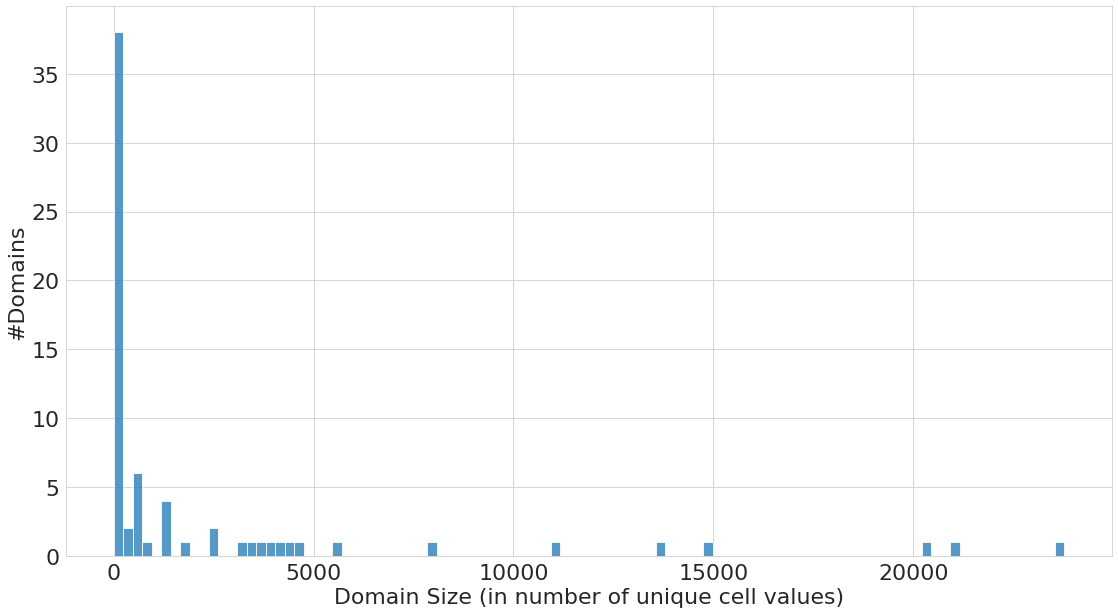

In [96]:
ax = sns.histplot(data=domains_df, x='num_cell_nodes', bins=100)
ax.set(xlabel='Domain Size (in number of unique cell values)', ylabel='#Domains')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_no_homographs_domain_size_histogram.svg')

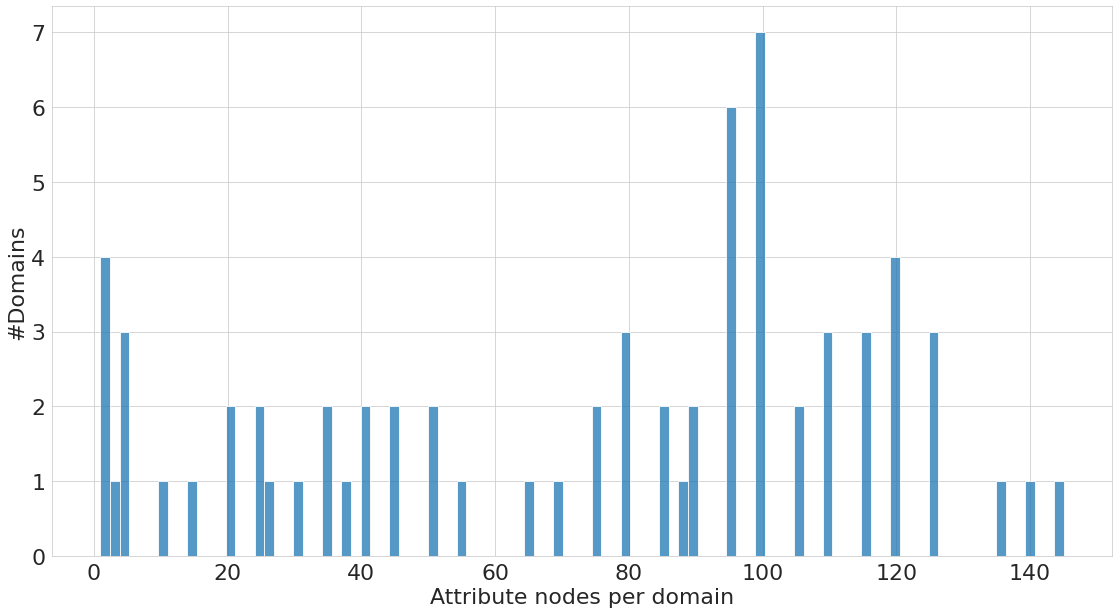

In [97]:
ax = sns.histplot(data=domains_df, x='num_attr_nodes', bins=100)
ax.set(xlabel='Attribute nodes per domain', ylabel='#Domains')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_no_homographs_attributes_per_domain_histogram.svg')

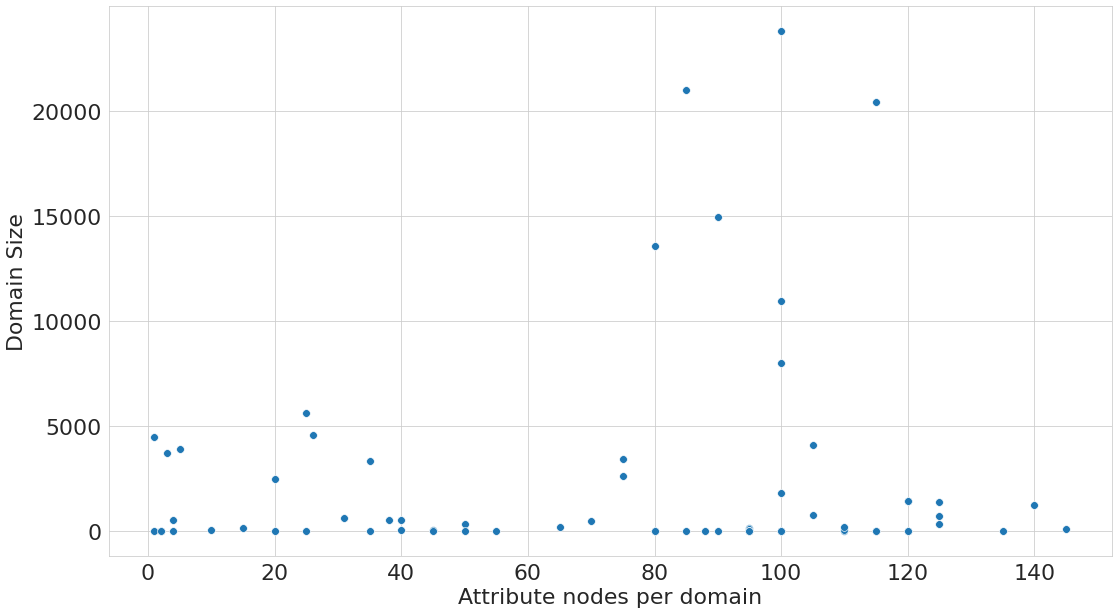

In [98]:
ax = sns.scatterplot(data=domains_df, x='num_attr_nodes', y='num_cell_nodes', s=60)
ax.set(xlabel='Attribute nodes per domain', ylabel='Domain Size')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_no_homographs_domain_size_vs_attributes_per_domain.svg')

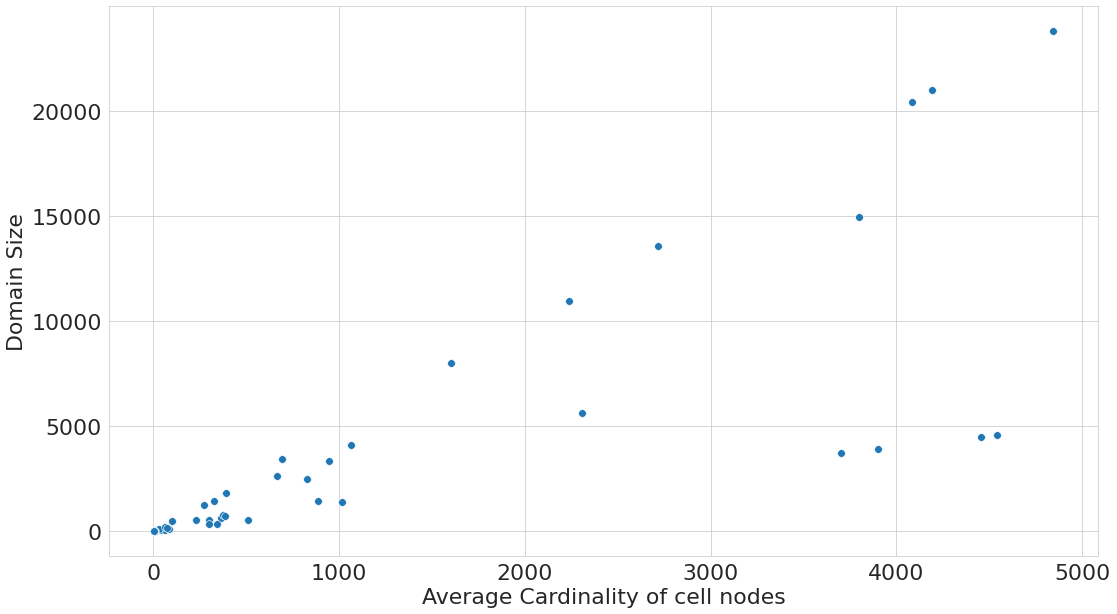

In [99]:
ax = sns.scatterplot(data=domains_df, x='avg_cell_card', y='num_cell_nodes', s=60)
ax.set(xlabel='Average Cardinality of cell nodes', ylabel='Domain Size')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_no_homographs_domain_size_vs_avg_cardinality.svg')

Bottom right 4 points correspond to: longitude/latitude, miles, and a rank in (2007 GradeX Crossings Inventory), 

# TUS 500 Injected Homographs 

In [52]:
# Read Graph
graph_path = '../graph_construction/combined_graphs_output/TUS_injected_homographs/bipartite/bipartite.graph'
df_path = 'output/TUS_injected_homographs/graph_stats_with_groundtruth_df.pickle'
domains_path = 'ground_truth/domain_info_injected_homographs.json'

g = pickle.load(open(graph_path, 'rb'))
df = pickle.load(open(df_path, 'rb'))
df = df[df['node_type'] == 'cell']

# Read domains
with open(domains_path) as f:
  data = json.load(f)
  attr_to_domains = data['attributes']
  domain_id_to_tuples = data['domains']

In [54]:
# Get mapping of each domain_id to the set of cell nodes in that domain
domain_id_to_cell_nodes = get_domain_to_cell_nodes_dict(g, attr_to_domains)

# Construct dictionaries
domain_id_to_num_cell_nodes = {id: len(domain_id_to_cell_nodes[id]) for id in domain_id_to_cell_nodes}
domain_id_to_num_attr_nodes = {int(id): len(domain_id_to_tuples[id]) for id in domain_id_to_tuples}
domain_id_to_col_names = get_domain_to_col_names_dict(domain_id_to_tuples)

# Populate dataframe with statistics
df_dict = {'domain_id': [], 'num_cell_nodes': [], 'num_attr_nodes': [], 'num_col_names': []}
for id in domain_id_to_num_cell_nodes:
    df_dict['domain_id'].append(id)
    df_dict['num_cell_nodes'].append(domain_id_to_num_cell_nodes[id])
    df_dict['num_attr_nodes'].append(domain_id_to_num_attr_nodes[id])
    df_dict['num_col_names'].append(len(domain_id_to_col_names[id]))
domains_df = pd.DataFrame.from_dict(df_dict)
domains_df

,domain_id,num_cell_nodes,num_attr_nodes,num_col_names
0,10,7,90,1
1,59,5,80,1
2,26,4,110,1
3,34,5,85,1
4,64,613,31,1
...,...,...,...,...
64,30,3,100,1
65,50,4,100,1
66,46,122,15,1
67,58,3329,35,1


In [55]:
# Map cell nodes to their set of domain IDs, and find cell nodes mapping to more than one domains
cell_node_to_domain_ids = get_cell_node_to_domain_ids_dict(domain_id_to_cell_nodes)
cell_nodes_in_multiple_domains = set()
for cell_node in cell_node_to_domain_ids:
    if len(cell_node_to_domain_ids[cell_node]) > 1:
        cell_nodes_in_multiple_domains.add(cell_node)
print("There are", len(cell_nodes_in_multiple_domains), "cell nodes that are placed in 2 or more domains.")

There are 500 cell nodes that are placed in 2 or more domains.


In [59]:
# Update df to classify homographs based the inferred domains definition
node_to_is_domain_homograph = {} 
for node in df['node']:
    if node in cell_nodes_in_multiple_domains:
        node_to_is_domain_homograph[node] = True
    else:
        node_to_is_domain_homograph[node] = False
df['is_domain_homograph'] = df['node'].map(node_to_is_domain_homograph)

# Update df to specify combined domain size for each cell node
node_to_total_domain_size = {}
for node in tqdm(df['node']):
    domains = cell_node_to_domain_ids[node]
    cell_nodes = set()
    for id in domains:
        cell_nodes.update(domain_id_to_cell_nodes[id])
    node_to_total_domain_size[node] = len(cell_nodes)
df['total_domain_size'] = df['node'].map(node_to_total_domain_size)

df = utils.calculate_eval_measures_from_gt_column(df, 'approximate_betweenness_centrality', 'is_domain_homograph', len(cell_nodes_in_multiple_domains))
df

100%|██████████| 163360/163360 [00:44<00:00, 3631.30it/s]


,node,node_type,approximate_betweenness_centrality,is_homograph,has_missing_key,is_domain_homograph,approximate_betweenness_centrality_rank,approximate_betweenness_centrality_dense_rank,approximate_betweenness_centrality_precision,approximate_betweenness_centrality_recall,approximate_betweenness_centrality_f1_score,total_domain_size
102339,InjectedHomograph154,cell,0.000181,True,False,True,1,1.0,1.000000,0.002,0.003992,4749
68888,InjectedHomograph330,cell,0.000083,True,False,True,2,2.0,1.000000,0.004,0.007968,44728
71291,InjectedHomograph41,cell,0.000081,True,False,True,3,3.0,1.000000,0.006,0.011928,44728
63234,InjectedHomograph184,cell,0.000073,True,False,True,4,4.0,1.000000,0.008,0.015873,25074
50627,InjectedHomograph23,cell,0.000067,True,False,True,5,5.0,1.000000,0.010,0.019802,37337
...,...,...,...,...,...,...,...,...,...,...,...,...
143681,Sessions d'information en r�gion,cell,0.000000,False,False,False,163356,866.0,0.003061,1.000,0.006103,23778
143680,Match making en r�gion,cell,0.000000,False,False,False,163357,866.0,0.003061,1.000,0.006103,23778
143679,Canada Research Chair in Water Quality & Treat...,cell,0.000000,False,False,False,163358,866.0,0.003061,1.000,0.006103,23778
143678,NSERC/Halifax Regional Water Commission Indust...,cell,0.000000,False,False,False,163359,866.0,0.003061,1.000,0.006103,23778


[0.92]


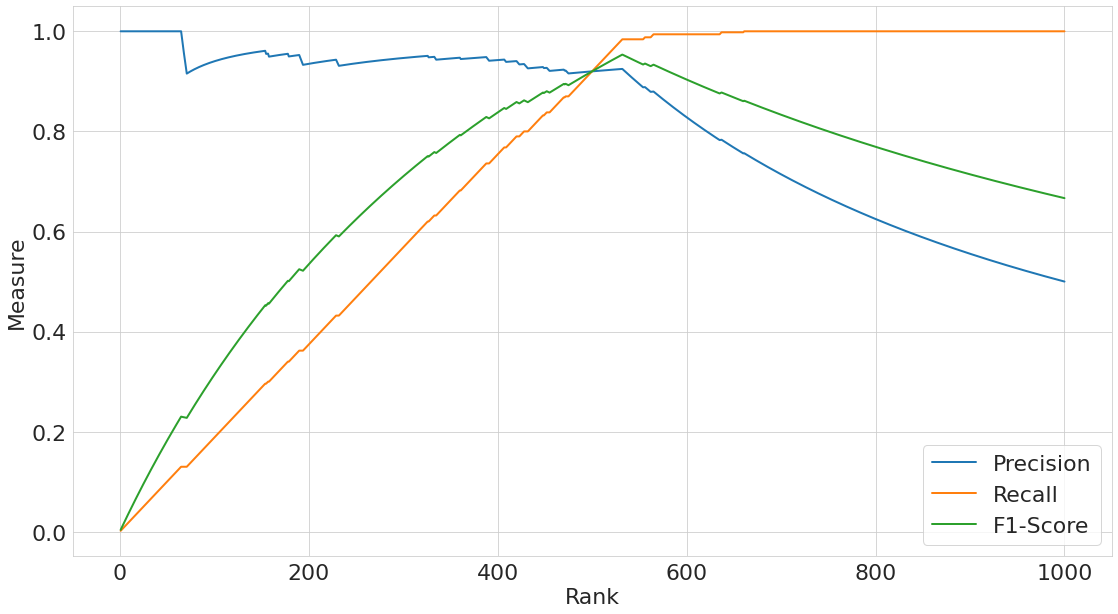

In [60]:
measure = 'approximate_betweenness_centrality'
k = 1000
ranks = list(range(1, k+1))

print(df[df[measure+"_rank"] == len(cell_nodes_in_multiple_domains)][measure+"_precision"].values)
plt.plot(ranks,df.sort_values(by=[measure+'_rank'])[measure+'_precision'].values[0:k], label='Precision', linewidth=2)
plt.plot(ranks,df.sort_values(by=[measure+'_rank'])[measure+'_recall'].values[0:k], label='Recall', linewidth=2)
plt.plot(ranks,df.sort_values(by=[measure+'_rank'])[measure+'_f1_score'].values[0:k], label='F1-Score', linewidth=2)
plt.xlabel('Rank')
plt.ylabel('Measure')
leg = plt.legend()
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_injected_homograph_BC_evalutation.svg')

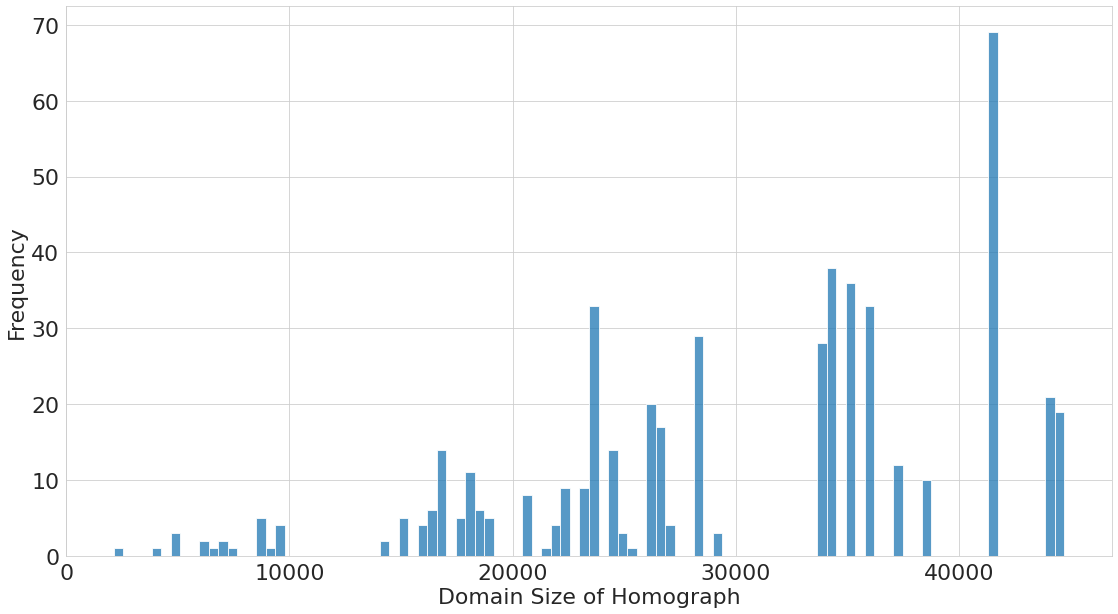

In [66]:
domain_homograph_df = df[df['is_domain_homograph'] == True]

ax = sns.histplot(data=domain_homograph_df, x='total_domain_size', bins=100)
ax.set(xlabel='Domain Size of Homograph', ylabel='Frequency')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_injected_homograph_domain_size_histogram.svg')

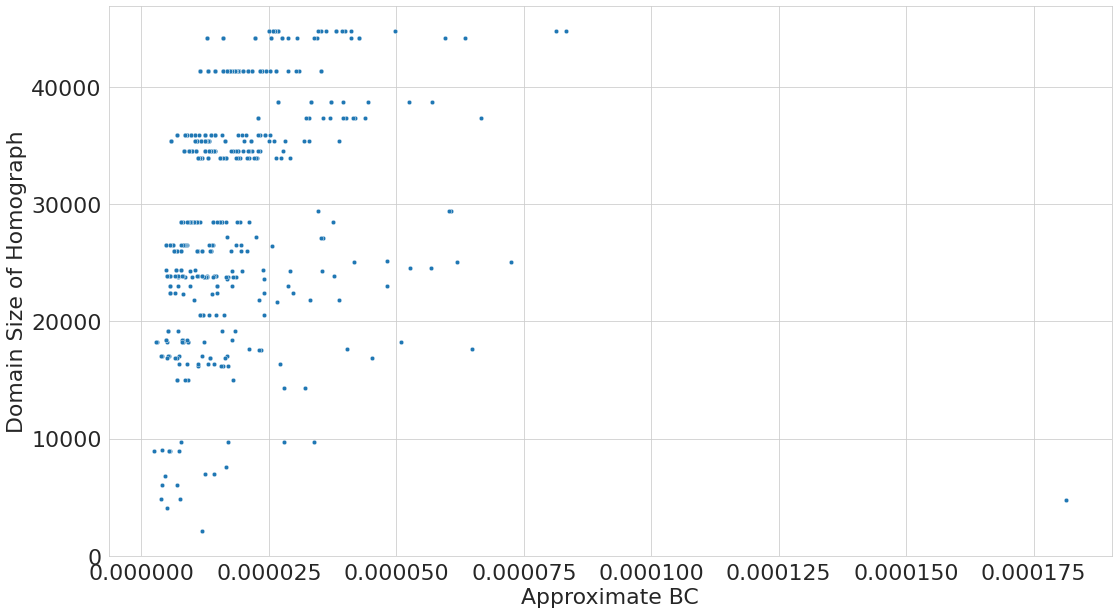

In [65]:
ax = sns.scatterplot(data=domain_homograph_df, x='approximate_betweenness_centrality', y='total_domain_size', s=20)
ax.set(xlabel='Approximate BC', ylabel='Domain Size of Homograph')
plt.tight_layout()
plt.savefig('figures/domain_analysis/TUS_injected_domain_size_vs_BC.svg')